# CSE378 Programming Assignment 3 -- DQN
🎃 **Happy Halloween! The Deep Reinforcement Learning algorithm is trick-or-treating!**

The goal of this assignment is to implement DQN algorithm.

- You will be using 4 Gymnasium environments, 2 state-based (Cartpole-v1 and MountainCar-v0) and 2 image-based (ALE/Breakout-v5 and ALE/Boxing-v5).
- Please use epsilon-greedy with epsilon-decay for the off-policy.
- We will use an MLP to implement Q network for state-based environemnts, and CNN for image-based environments.
- This time we will need the **GPU runtime** of Colab. Make sure you are on it and implement your algorithm parts based on that (e.g. move the network and inputs to GPU). Be patient when training on image-based environments.

###Please only add/change the part surrounded by the marks below
```
#====Please write your codes here======

#======================================
```

###Submission

Please submit the required materials through Brightspace. The instructions are below and they are also available in Brightspace:

- Please find the assignment in attached colab or this link https://colab.research.google.com/drive/1LmLuRigKilQRHgENd9i_8oiv0IjBGwGR?usp=sharing. Oh you are actually viewing this colab, good job!

- Please use your **@stonybrook.edu** account to access the assignment colab and edit its copy.

- For submission, please submit **(1) a link to your finished colab and (2) a copy of your colab file.**
  - To get the link and share it, please reach to colab top right -- share->general access->select Stony Brook University, and submit the link in this assignment.
  - To get a copy of your colab, reach to colab top left -- file->download->download .ipynb. The format of the submitted filename will follow \<SBUID\>_\<last name\>_\<first name\>_cse378pa3.ipynb. For example: 123445678_carrot_melon_cse378pa3.ipynb
  - Make sure that once the TA clicks [Run all], the algorithm works and reproduces the results in the submission.

###Grading
- Consider full points of 100.
- Code of replay buffer (10 points).
- Code of Q network for state-based and image-based (20 points - 10 points each).
- Core cods of DQN algorithms with comments. The comments should reflect your understanding or design of the algorithm. ( 30 points )
- 4 plots (1 per environment): the cumulative rewards (Y-axis) vs # of episodes (X-axis), to show the trends of rewards during learning. (20 points in total -- 5 point each x 4)
- Evaluation of the final policy of each environment. Run the final policy tens of times, and average the return. Then give the results and conclusion. (20 points in total -- 5 points each x 4)
- Note on rubric: the assignment will focus on implementing the algorithm correctly. The actual performance, e.g., how much cumulative rewards the algorithms got, are not important. However, if the algorithm is not correct, there is a high chance that the evaluation reward is not high.

###Late Submission Policy
The late submission penalty will be 10% grade of that assignment per late day (24 hours). The final grade of a late submitted assignment = (1 - pentalty) * your original grade.
For example, being late for 3 hours will count for 1 day and get 90% of your orignal grade; being late for 1 day + 2 hours will count for 2 days and get 80% of your original grade.

##Due: 11/21 1:00PM

In [1]:
!pip install gymnasium[classic-control,atari,accept-rom-license]
!pip install opencv-python

In [2]:
import imageio
from IPython.display import Image, display
from io import BytesIO

# Code for visualizing the episode

class GIFMaker:
    def __init__(self):
        self.reset()

    def reset(self):
        self.images = []
        self.buffer = BytesIO()

    def append(self, img):
        self.images.append(img)

    def display(self):
        imageio.mimsave(self.buffer, self.images, format='gif')
        gif = Image(data=self.buffer.getvalue())
        display(gif)
        return gif

    def __len__(self):
      return len(self.images)

## Env1 CartPole-v1
Detailed information of this environment:
https://gymnasium.farama.org/environments/classic_control/cart_pole/

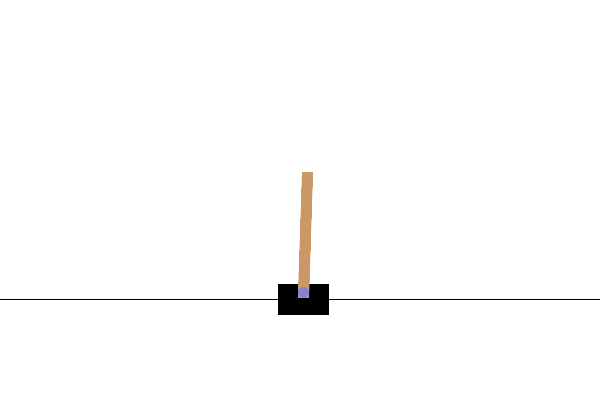

In [3]:
import gymnasium as gym
env = gym.make("CartPole-v1", render_mode="rgb_array")
g = GIFMaker() # visualization
observation, info = env.reset(seed=42)
for i in range(500):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    # print(i, action, observation, reward)
    g.append(env.render()) # save one frame
    if terminated or truncated:
        observation, info = env.reset()
        break
g.display() # show GIF animation
env.close()

## Env2 MountainCar-v0
Detailed information of this environment: https://gymnasium.farama.org/environments/classic_control/mountain_car/

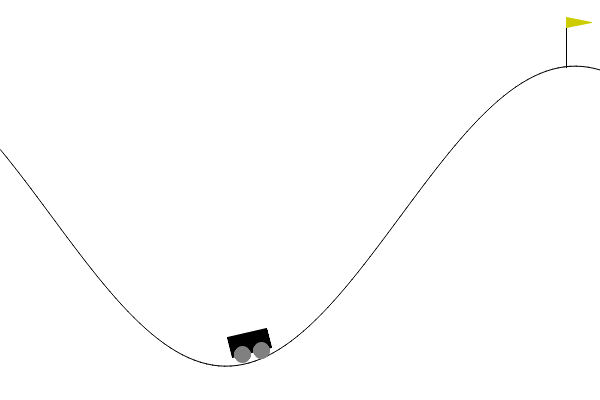

In [4]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")

observation, info = env.reset(seed=42)
g = GIFMaker()
for i in range(200):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    # print(i, action, observation, reward)
    g.append(env.render())
    if terminated or truncated:
        observation, info = env.reset()
        break
g.display()
env.close()

## Env3 Breakout, an Atari game
Detailed information of this environment: https://gymnasium.farama.org/environments/atari/breakout/

c:\Python\Lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


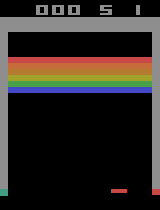

In [5]:
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")

observation, info = env.reset(seed=42)
g = GIFMaker()
for i in range(200):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    # print(i, action, observation, reward)
    g.append(env.render())
    if terminated or truncated:
        observation, info = env.reset()
        break
g.display()
env.close()

## Env4 Boxing, an Atari game
Detailed information of this environment: https://gymnasium.farama.org/environments/atari/breakout/

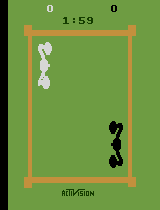

In [6]:
env = gym.make("ALE/Boxing-v5", render_mode="rgb_array")

observation, info = env.reset(seed=42)
g = GIFMaker()
for i in range(200):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    # print(i, action, observation, reward)
    g.append(env.render())
    if terminated or truncated:
        observation, info = env.reset()
        break
g.display()
env.close()

##Import packages we need

In [7]:
import os
import gc
import math
import random

from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import deque

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2

##Replay Buffer
Let's implement a replay buffer with size n. (Different task/environment may use buffers in different sizes.)

In [126]:
class ReplayBuffer(object):
    def __init__(self, n):
        # ====Please write your codes here======
        self.buffer = deque([], maxlen=n) # you can think about this is a Python list, but automatically keeping its size <= maxlen
        # ======================================


    def add(self, x):
        # ====Please write your codes here======
        # add sample x to the buffer
        # you can regard sample x as a whole "package" of a transition (e.g. (state,action,reward,next_state...))
        # and don't worry about what's in it for now
        self.buffer.append(x)
        # ======================================

    def sample(self, batch_size):
        # ====Please write your codes here======
        # randomly sample a batch from the buffer
        # return a list of "packages" before
        return random.sample(self.buffer, batch_size)
       
        # ======================================

    def __len__(self):
        return len(self.buffer)

##DQN for numerical states

In [223]:
# MLP for Q function network
class QNetwork(nn.Module):
    def __init__(
        self,
        state_dim,
        action_dim
    ):
        super(QNetwork, self).__init__()
        # ====Please write your codes here======
        # the output dimension should be action_dim
        # which gives us Q values for all actions
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64, action_dim)
        
        # ======================================

    def forward(self, x):
        # ====Please write your codes here======
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        # ======================================

# DQN
class DQN():
    def __init__(
        self,
        env,
        env_name,
        eps=0.1,
        eps_decay_steps=20000,
        batch_size=64,
        train_freq=4,
        target_network_update_freq=200,
        train_start=2000,
        gamma=0.95,
        # please check these paremeters and understand their usages in the algorithm
        # for educational purpose, you can adjust them out of your curiosity and find out how they affect the learning
    ):
        # initlize env and env name
        self.env = env
        self.env_name = env_name

        # set state dimension and number of actions
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n

        # ====Please write your codes here======
        # create two networks: 1) Policy (online) network, 2) Target network
        self.policy_network = QNetwork(self.state_dim, self.action_dim)
        self.target_network = QNetwork(self.state_dim, self.action_dim)
        # ======================================


        # ====Please write your codes here======
        # make target network paramters same as policy network
        # you can take advantage of load_state_dict() in pytorch
        self.target_network.load_state_dict(self.policy_network.state_dict())
        # ======================================


        # assign gpu if available
        # note: if you run a cpu, it could be slow
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


        # ====Please write your codes here======
        # move the networks to device/gpu
        self.policy_network.to(self.device)
        self.target_network.to(self.device)
        # ======================================


        # ====Please write your codes here======
        # Create Replay Buffer with size 50000
        self.buffer = ReplayBuffer(50000)
        # ======================================

        # (end) epsilon value for epsilon off policy (self.eps)
        self.eps = eps
        # how many steps epsilon decays from 1 to eps
        self.eps_decay_steps = eps_decay_steps


        # ====Please write your codes here======
        # set optimizer and loss function
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr = 0.001, amsgrad=True)
        self.loss_fn = nn.MSELoss()
        # ======================================

        # batch size for sampling data from replay buffer
        self.batch_size = batch_size

        # mode is used to switch between optimization of DQN and Evaluation
        self.mode = "eval"
        self.total_transitions = 0
        self.train_freq = train_freq
        self.target_network_update_freq = target_network_update_freq
        self.train_start = train_start

        self.gamma = gamma
        self.g = None # for visualization


    # function to choose action given a state
    # needs to return a pytorch Tensor, so when you create some random thing
    # please make sure it converts to Tensor (note: remember to include the batch dimension!)
    # you can use torch.tensor(<some_array>, device=self.device, dtype=<the_type_you_want>)
    def act(self, state):
        with torch.no_grad():
            if self.mode == "eval":
                # ====Please write your codes here======
                # during evaluation 
                action = self.policy_network(state).max(1).indices.view(1,1)

                # ======================================
                return action
            elif self.mode == "train":
                if self.total_transitions < self.train_start:
                    # ====Please write your codes here======
                    # before actually learning, do random actions
                    return torch.tensor([[env.action_space.sample()]], device=self.device, dtype=torch.long)
                    # ======================================
                    

                # ====Please write your codes here======
                # actual eps value for epsilon greedy
                # here we consider a linear epsilon decay
                # the actual eps value is 1 when total_transition is 0
                # the actual eps value is self.eps if it is greater than self.eps_decay_steps (i.e. the end of decaying)
                # in between them, just linearly decay the eps value according to how many steps (self.total_transitions) this DQN runs.
                if self.total_transitions ==  0:
                    eps = 1
                else:
                    eps = self.eps
                # ======================================


                # ====Please write your codes here======
                # epsilon-greedy policy
                # return an action according to eps
                sample = random.random()
                if (sample > eps):
                    with torch.no_grad():
                        return self.policy_network(state).max(1).indices.view(1,1)
                else:
                    return torch.tensor([[env.action_space.sample()]], device=self.device, dtype=torch.long)

                # ======================================

    # optimizae the DQN
    def optimization(self):
        # make sure the policy network is train mode
        self.policy_network.train()

        # get a batch of state, action, next state, and reward and append them to convert to batch of tensors
        state, action, next_state, reward, not_done = list(zip(*self.buffer.sample(self.batch_size)))
        state = torch.cat(state, dim=0).to(self.device)
        # ====Please write your codes here======
        # given the example of state, please complete what should we do for action, next_state, reward, and not_done
        action = torch.cat(action, dim=0).to(self.device)
        next_state = torch.cat(next_state, dim=0).to(self.device)
        reward = torch.cat(reward, dim=0).to(self.device)
        # ======================================

        # ====Please write your codes here======
        # implement how you update the policy network based on that batch
        # this includes q value calculation, loss compute, and backprop
        # note: you may need "with torch.no_grad():" or "detach()" when preventing gradient from going through target network
        q_values = self.policy_network(state).gather(1, action)
        next_q_values = torch.zeros(self.batch_size, device = self.device)
        with torch.no_grad():
            next_q_values = self.target_network(next_state).max(1)[0].detach()
            
        target_q_values = (next_q_values * self.gamma) + reward

        loss = self.loss_fn(q_values, target_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ======================================


        # ====Please write your codes here======
        # Update the target network based on new policy network paramters
        # we do update every other self.target_network_update_freq steps, this is to ensure the training stability
        # similar to initially copying the parameters from policy to target
        if self.total_transitions % self.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.policy_network.state_dict())
        # ======================================


    # run for one episode
    def run_one_episode(self):
        self.g = GIFMaker()

        # batch_size for training network
        batch_size = 64

        # initialize some values to track the end of current episode and cummulative reward
        terminated = False
        r = 0


        # ====Please write your codes here======
        # reset the environment
        self.state,_ = self.env.reset()
        # ======================================
        self.g.append(env.render())

        while not terminated:
            # ====Please write your codes here======
            # create state_tensor that converts from state, and make a batch dimension, move it to gpu
            # create action_tensor which we follow the epsilon policy, use act()
            # take that action in the environment and observe the next state
            # we need to use .item() on action_tensor to make it a number for the environment
            state_tensor = torch.tensor(self.state, dtype=torch.float32, device=self.device).unsqueeze(0)
            action_tensor = self.act(state_tensor)
            next_state, reward, terminated, truncated, _ = self.env.step(action_tensor.item())
            # ======================================
            r += reward 
            self.g.append(env.render())


            # ====Please write your codes here======
            # create next_state_tensor as a tensor
            # create reward_tensor as a tensor
            # create a binary (0, 1) variable for not_done: 1 for not done and 0 for done
            # remember the batch dimension!
            # we don't need move them to the gpu
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            reward_tensor = torch.tensor([reward], dtype=torch.float32).unsqueeze(0)
            not_done = 1 if not terminated else 0
            not_done_tensor = torch.tensor(not_done, dtype=torch.float32)
            # ======================================

            if self.mode == "train":
                self.total_transitions += 1

                # ====Please write your codes here======
                # add state, action, next state and reward tensors to buffer, using the add() method of the buffer class
                # note: move state_tensor and action_tensor back to cpu to avoid filling up GPU
                # note: we organize those elements in a list [state, action, ... so on] and add it to the buffer
                self.buffer.add([state_tensor.cpu(), action_tensor.cpu(), next_state_tensor, reward_tensor, not_done])
                # ======================================

                if len(self.buffer) < self.train_start:
                    # don't train before train_start, just gathering more samples
                    continue
                else:
                    # ====Please write your codes here======
                    # we optimize the network for every other self.train_freq steps
                    if self.total_transitions % self.train_freq == 0:
                        self.optimization()
                    # ======================================

            # Terminated then return
            if terminated or truncated:
                return r

            # don't forget to assign next_state to state for the next loop
            # ====Please write your codes here======
            self.state = next_state
            # ======================================

        return r

    def train(self):
        self.mode = "train"
        r = self.run_one_episode()
        # print(f"Training Reward: {r:.2f}") # optionally print out reward of this episode in case you are boring

    # Evaluation of policy
    def eval(self, n):
        self.mode = "eval" # put in eval mode
        returns = []
        for i in range(n):                          # run evaluation for n episode
            returns.append(self.run_one_episode())
        return np.mean(returns)                    # return average returns over niter episodes


    # the function called to perform optimization and evaluation
    def execute(self, total_ep=5000, eval_freq=100, eval_ep=100):
        rewards = []   # used to track polciy evaluation across runs
        episodes = []  # number of episodes used to update policy

        prog_bar = tqdm(range(0, total_ep))
        for i in prog_bar:
            self.train()                        # train
            if (i+1) % eval_freq == 0:          # evaluate using eval_ep episodes every eval_freq policy updates
                reward = self.eval(eval_ep)
                print (f"Eval Reward: {reward:.2f}")
                rewards.append(reward)
                episodes.append(i)

        plt.plot(episodes, rewards)   # plot evaluation reward vs episodes
        plt.xlabel('episodes')
        plt.ylabel('Rewards')
        plt.title('DQN on '+self.env_name)
        plt.show()

    def visualize(self):
        self.g.display()

  3%|▎         | 101/3000 [00:11<28:02,  1.72it/s]

Eval Reward: 16.38


  7%|▋         | 200/3000 [00:53<5:23:19,  6.93s/it]

Eval Reward: 73.13


 10%|█         | 300/3000 [01:42<5:20:08,  7.11s/it]

Eval Reward: 63.12


 13%|█▎        | 400/3000 [02:29<4:46:11,  6.60s/it]

Eval Reward: 67.56


 17%|█▋        | 500/3000 [03:17<4:55:46,  7.10s/it]

Eval Reward: 73.15


 20%|██        | 600/3000 [04:07<5:22:56,  8.07s/it]

Eval Reward: 84.51


 23%|██▎       | 700/3000 [04:41<1:52:24,  2.93s/it]

Eval Reward: 39.80


 27%|██▋       | 801/3000 [05:38<3:50:34,  6.29s/it]

Eval Reward: 123.94


 30%|███       | 901/3000 [06:41<5:22:50,  9.23s/it]

Eval Reward: 138.87


 33%|███▎      | 1003/3000 [07:06<19:23,  1.72it/s] 

Eval Reward: 9.94


 37%|███▋      | 1100/3000 [07:42<2:38:53,  5.02s/it]

Eval Reward: 50.37


 40%|████      | 1200/3000 [08:26<2:48:48,  5.63s/it]

Eval Reward: 58.70


 43%|████▎     | 1300/3000 [09:25<5:04:35, 10.75s/it]

Eval Reward: 110.56


 47%|████▋     | 1401/3000 [10:22<3:01:11,  6.80s/it]

Eval Reward: 96.06


 50%|█████     | 1500/3000 [10:54<58:33,  2.34s/it]  

Eval Reward: 21.60


 53%|█████▎    | 1601/3000 [11:33<1:05:13,  2.80s/it]

Eval Reward: 38.42


 57%|█████▋    | 1700/3000 [12:20<2:19:07,  6.42s/it]

Eval Reward: 64.39


 60%|██████    | 1800/3000 [12:51<31:59,  1.60s/it]  

Eval Reward: 22.08


 63%|██████▎   | 1901/3000 [13:32<55:14,  3.02s/it]  

Eval Reward: 43.51


 67%|██████▋   | 2000/3000 [14:42<3:51:24, 13.88s/it]

Eval Reward: 144.95


 70%|███████   | 2100/3000 [15:14<34:37,  2.31s/it]  

Eval Reward: 14.44


 73%|███████▎  | 2200/3000 [15:55<1:07:53,  5.09s/it]

Eval Reward: 52.84


 77%|███████▋  | 2301/3000 [16:30<39:47,  3.42s/it]  

Eval Reward: 47.83


 80%|████████  | 2400/3000 [17:32<2:02:38, 12.26s/it]

Eval Reward: 130.42


 83%|████████▎ | 2500/3000 [18:24<1:18:18,  9.40s/it]

Eval Reward: 100.35


 87%|████████▋ | 2600/3000 [19:03<38:12,  5.73s/it]  

Eval Reward: 60.09


 90%|█████████ | 2700/3000 [19:41<23:10,  4.63s/it]

Eval Reward: 56.79


 93%|█████████▎| 2801/3000 [20:28<19:35,  5.91s/it]

Eval Reward: 86.62


 97%|█████████▋| 2901/3000 [21:13<09:23,  5.70s/it]

Eval Reward: 83.17


100%|██████████| 3000/3000 [21:34<00:00,  2.32it/s]

Eval Reward: 15.36


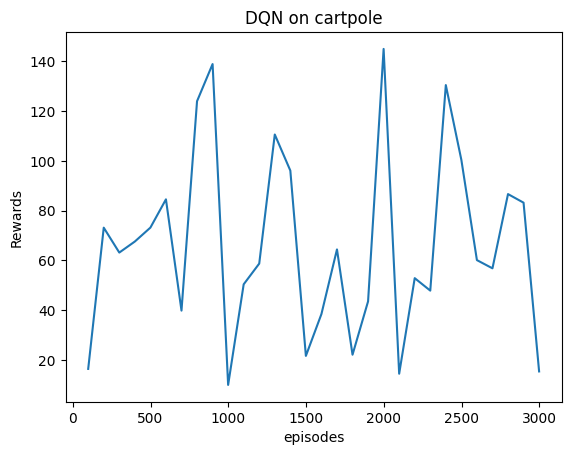

In [224]:
# Cart Pole DQN
gc.collect() # free some unused RAM, don't worry about this
env = gym.make("CartPole-v1", render_mode="rgb_array")
dqn_cartpole = DQN(env, "cartpole", eps=0.01, batch_size=64)
dqn_cartpole.execute(total_ep=3000, eval_freq=100, eval_ep=100) # total_ep=5000 will take ~25 mins on GPU
# you can make total_ep, train_start, eps_decay_steps, or any other arguments small when debugging the algorithm
# !![to produce the plot for submission, please run at least 3000 episodes]

In [209]:
# your final evaluation of the learned policy
# ====Please write your codes here======
print(f"Average reward: {dqn_cartpole.eval(10)}")
# ======================================

Average reward: 28.9


  5%|▌         | 100/2000 [01:43<2:32:33,  4.82s/it]

Eval Reward: -200.00


 10%|█         | 200/2000 [03:30<2:39:20,  5.31s/it]

Eval Reward: -200.00


 15%|█▌        | 300/2000 [05:22<2:20:58,  4.98s/it]

Eval Reward: -200.00


 20%|██        | 400/2000 [07:17<2:17:53,  5.17s/it]

Eval Reward: -200.00


 25%|██▌       | 500/2000 [09:07<2:08:07,  5.12s/it]

Eval Reward: -200.00


 30%|███       | 600/2000 [10:56<1:57:57,  5.06s/it]

Eval Reward: -200.00


 35%|███▌      | 700/2000 [12:44<1:38:06,  4.53s/it]

Eval Reward: -174.50


 40%|████      | 800/2000 [14:34<1:38:36,  4.93s/it]

Eval Reward: -200.00


 45%|████▌     | 900/2000 [16:23<1:30:30,  4.94s/it]

Eval Reward: -200.00


 50%|█████     | 1000/2000 [18:12<1:22:24,  4.94s/it]

Eval Reward: -200.00


 55%|█████▌    | 1100/2000 [20:01<1:15:58,  5.07s/it]

Eval Reward: -200.00


 60%|██████    | 1200/2000 [21:50<1:06:12,  4.97s/it]

Eval Reward: -200.00


 65%|██████▌   | 1300/2000 [23:41<58:07,  4.98s/it]  

Eval Reward: -200.00


 70%|███████   | 1400/2000 [25:34<55:58,  5.60s/it]

Eval Reward: -200.00


 75%|███████▌  | 1500/2000 [27:23<41:01,  4.92s/it]

Eval Reward: -200.00


 80%|████████  | 1600/2000 [29:12<33:47,  5.07s/it]

Eval Reward: -200.00


 85%|████████▌ | 1700/2000 [31:02<24:47,  4.96s/it]

Eval Reward: -200.00


 90%|█████████ | 1800/2000 [32:51<16:45,  5.03s/it]

Eval Reward: -200.00


 95%|█████████▌| 1900/2000 [34:40<08:19,  5.00s/it]

Eval Reward: -200.00


100%|██████████| 2000/2000 [36:30<00:00,  1.10s/it]

Eval Reward: -200.00


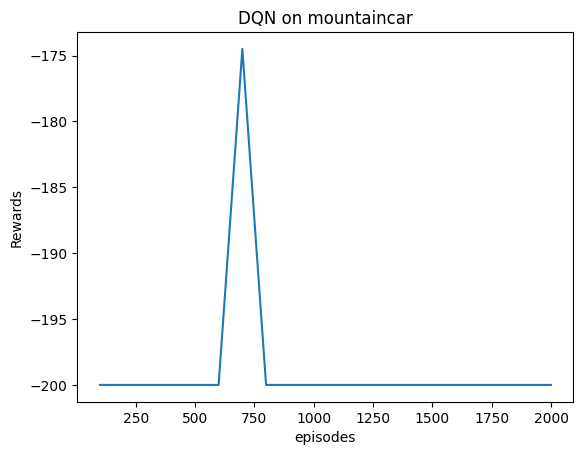

In [226]:
# Mountain Car DQN
gc.collect() # free some unused RAM, don't worry about this
env = gym.make("MountainCar-v0", render_mode="rgb_array")
dqn_mountaincar = DQN(env, "mountaincar", eps=0.2, batch_size=64)
dqn_mountaincar.execute(total_ep=2000, eval_freq=100, eval_ep=20) # 2000 episodes take ~34 mins
# !![to produce the plot for submission, please run at least 2000 episodes]

In [ ]:
# your final evaluation of the learned policy
# ====Please write your codes here======
print(f"Average reward: {dqn_mountaincar.eval(10)}")
# ======================================

#DQN for image states (observations)

In [260]:
# Almost all the code stubs above can be reused for this part
# The things you need to change are
# 1. The Q network architecture. We need CNN to process images.
#    The CNN should deal with images inputs (C, 84, 84), where C is the number of channels of the image. C=1 if gray-scale image, C=3 if rgb.
#    reference: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
# 2. Resize images using opencv-python. You are required to resize the image to 84x84. Then apply a normalization on original RGB values.
#    reference: https://www.geeksforgeeks.org/image-resizing-using-opencv-python/#

# ====Please write your codes here======
class QNetwork_Image(nn.Module):
    def __init__(self, output):
        super(QNetwork_Image, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, output)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def resize_and_normalize(state, image_size=(84, 84)):
    # use opencv cv2.resize() to resize the input image to image_size (84, 84)
    # normalization the image to 0-1 (note: be careful on data types! opencv gives us nparray with np.uint8, however, for normalization, we need convert to float value first)
    # convert to pytorch's channel first image representation
    # if your image is rgb, pytorch accepts shape (3, H, W)
    # if your image is gray-scale, pytorch accepts shape (1, H, W)
    # we don't need to convert to tensor for now, just numpy array
    resized_state = cv2.resize(state, image_size)
    normalized_state = cv2.normalize(resized_state, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    return normalized_state

class DQN_Image():
    # just copy paste what you have above in state-based DQN
    # and apply resize_and_normalize() somewhere to transform the image state correctly.
    
    def __init__(
        self,
        env,
        env_name,
        eps=0.1,
        eps_decay_steps=20000,
        batch_size=64,
        train_freq=4,
        target_network_update_freq=200,
        train_start=2000,
        gamma=0.95,
        # please check these paremeters and understand their usages in the algorithm
        # for educational purpose, you can adjust them out of your curiosity and find out how they affect the learning
    ):
        # initlize env and env name
        self.env = env
        self.env_name = env_name

        # set state dimension and number of actions
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        # ====Please write your codes here======
        # create two networks: 1) Policy (online) network, 2) Target network
        self.policy_network = QNetwork_Image(self.action_dim)
        self.target_network = QNetwork_Image(self.action_dim)
        # ======================================


        # ====Please write your codes here======
        # make target network paramters same as policy network
        # you can take advantage of load_state_dict() in pytorch
        self.target_network.load_state_dict(self.policy_network.state_dict())
        # ======================================


        # assign gpu if available
        # note: if you run a cpu, it could be slow
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


        # ====Please write your codes here======
        # move the networks to device/gpu
        self.policy_network.to(self.device)
        self.target_network.to(self.device)
        # ======================================


        # ====Please write your codes here======
        # Create Replay Buffer with size 50000
        self.buffer = ReplayBuffer(50000)
        # ======================================

        # (end) epsilon value for epsilon off policy (self.eps)
        self.eps = eps
        # how many steps epsilon decays from 1 to eps
        self.eps_decay_steps = eps_decay_steps


        # ====Please write your codes here======
        # set optimizer and loss function
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr = 0.001, amsgrad=True)
        self.loss_fn = nn.MSELoss()
        # ======================================

        # batch size for sampling data from replay buffer
        self.batch_size = batch_size

        # mode is used to switch between optimization of DQN and Evaluation
        self.mode = "eval"
        self.total_transitions = 0
        self.train_freq = train_freq
        self.target_network_update_freq = target_network_update_freq
        self.train_start = train_start

        self.gamma = gamma
        self.g = None # for visualization


    # function to choose action given a state
    # needs to return a pytorch Tensor, so when you create some random thing
    # please make sure it converts to Tensor (note: remember to include the batch dimension!)
    # you can use torch.tensor(<some_array>, device=self.device, dtype=<the_type_you_want>)
    def act(self, state):
        with torch.no_grad():
            if self.mode == "eval":
                # ====Please write your codes here======
                # during evaluation 
                action = self.policy_network(state).max(1).indices.view(1,1)

                # ======================================
                return action
            elif self.mode == "train":
                if self.total_transitions < self.train_start:
                    # ====Please write your codes here======
                    # before actually learning, do random actions
                    return torch.tensor([[env.action_space.sample()]], device=self.device, dtype=torch.long)
                    # ======================================
                    

                # ====Please write your codes here======
                # actual eps value for epsilon greedy
                # here we consider a linear epsilon decay
                # the actual eps value is 1 when total_transition is 0
                # the actual eps value is self.eps if it is greater than self.eps_decay_steps (i.e. the end of decaying)
                # in between them, just linearly decay the eps value according to how many steps (self.total_transitions) this DQN runs.
                if self.total_transitions ==  0:
                    eps = 1
                else:
                    eps = self.eps
                # ======================================


                # ====Please write your codes here======
                # epsilon-greedy policy
                # return an action according to eps
                sample = random.random()
                if (sample > eps):
                    with torch.no_grad():
                        return self.policy_network(state).max(1).indices.view(1,1)
                else:
                    return torch.tensor([[env.action_space.sample()]], device=self.device, dtype=torch.long)

                # ======================================

    # optimizae the DQN
    def optimization(self):
        # make sure the policy network is train mode
        self.policy_network.train()

        # get a batch of state, action, next state, and reward and append them to convert to batch of tensors
        state, action, next_state, reward, not_done = list(zip(*self.buffer.sample(self.batch_size)))

        state = resize_and_normalize(state,image_size=(84,84))

        state = torch.cat(state, dim=0).to(self.device)
        # ====Please write your codes here======
        # given the example of state, please complete what should we do for action, next_state, reward, and not_done
        action = torch.cat(action, dim=0).to(self.device)
        next_state = torch.cat(next_state, dim=0).to(self.device)
        reward = torch.cat(reward, dim=0).to(self.device)
        # ======================================

        # ====Please write your codes here======
        # implement how you update the policy network based on that batch
        # this includes q value calculation, loss compute, and backprop
        # note: you may need "with torch.no_grad():" or "detach()" when preventing gradient from going through target network
        q_values = self.policy_network(state).gather(1, action)
        next_q_values = torch.zeros(self.batch_size, device = self.device)
        with torch.no_grad():
            next_q_values = self.target_network(next_state).max(1)[0].detach()
            
        target_q_values = (next_q_values * self.gamma) + reward

        loss = self.loss_fn(q_values, target_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ======================================


        # ====Please write your codes here======
        # Update the target network based on new policy network paramters
        # we do update every other self.target_network_update_freq steps, this is to ensure the training stability
        # similar to initially copying the parameters from policy to target
        if self.total_transitions % self.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.policy_network.state_dict())
        # ======================================


    # run for one episode
    def run_one_episode(self):
        self.g = GIFMaker()

        # batch_size for training network
        batch_size = 64

        # initialize some values to track the end of current episode and cummulative reward
        terminated = False
        r = 0


        # ====Please write your codes here======
        # reset the environment
        self.state,_ = self.env.reset()
        # ======================================
        self.g.append(env.render())

        while not terminated:
            # ====Please write your codes here======
            # create state_tensor that converts from state, and make a batch dimension, move it to gpu
            # create action_tensor which we follow the epsilon policy, use act()
            # take that action in the environment and observe the next state
            # we need to use .item() on action_tensor to make it a number for the environment
            state_tensor = torch.tensor(self.state, dtype=torch.float32, device=self.device).unsqueeze(0)
            action_tensor = self.act(state_tensor)
            next_state, reward, terminated, truncated, _ = self.env.step(action_tensor.item())
            # ======================================
            r += reward 
            self.g.append(env.render())


            # ====Please write your codes here======
            # create next_state_tensor as a tensor
            # create reward_tensor as a tensor
            # create a binary (0, 1) variable for not_done: 1 for not done and 0 for done
            # remember the batch dimension!
            # we don't need move them to the gpu
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            reward_tensor = torch.tensor([reward], dtype=torch.float32).unsqueeze(0)
            not_done = 1 if not terminated else 0
            not_done_tensor = torch.tensor(not_done, dtype=torch.float32)
            # ======================================

            if self.mode == "train":
                self.total_transitions += 1

                # ====Please write your codes here======
                # add state, action, next state and reward tensors to buffer, using the add() method of the buffer class
                # note: move state_tensor and action_tensor back to cpu to avoid filling up GPU
                # note: we organize those elements in a list [state, action, ... so on] and add it to the buffer
                self.buffer.add([state_tensor.cpu(), action_tensor.cpu(), next_state_tensor, reward_tensor, not_done])
                # ======================================

                if len(self.buffer) < self.train_start:
                    # don't train before train_start, just gathering more samples
                    continue
                else:
                    # ====Please write your codes here======
                    # we optimize the network for every other self.train_freq steps
                    if self.total_transitions % self.train_freq == 0:
                        self.optimization()
                    # ======================================

            # Terminated then return
            if terminated or truncated:
                return r

            # don't forget to assign next_state to state for the next loop
            # ====Please write your codes here======
            self.state = next_state
            # ======================================

        return r

    def train(self):
        self.mode = "train"
        r = self.run_one_episode()
        # print(f"Training Reward: {r:.2f}") # optionally print out reward of this episode in case you are boring

    # Evaluation of policy
    def eval(self, n):
        self.mode = "eval" # put in eval mode
        returns = []
        for i in range(n):                          # run evaluation for n episode
            returns.append(self.run_one_episode())
        return np.mean(returns)                    # return average returns over niter episodes


    # the function called to perform optimization and evaluation
    def execute(self, total_ep=5000, eval_freq=100, eval_ep=100):
        rewards = []   # used to track polciy evaluation across runs
        episodes = []  # number of episodes used to update policy

        prog_bar = tqdm(range(0, total_ep))
        for i in prog_bar:
            self.train()                        # train
            if (i+1) % eval_freq == 0:          # evaluate using eval_ep episodes every eval_freq policy updates
                reward = self.eval(eval_ep)
                print (f"Eval Reward: {reward:.2f}")
                rewards.append(reward)
                episodes.append(i)

        plt.plot(episodes, rewards)   # plot evaluation reward vs episodes
        plt.xlabel('episodes')
        plt.ylabel('Rewards')
        plt.title('DQN on '+self.env_name)
        plt.show()

    def visualize(self):
        self.g.display()  
# ======================================


In [261]:
# Breakout DQN
# breakout could be a bit hard to learn
gc.collect()
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array", obs_type="grayscale") # optionally you can try obs_type=rgb, which gives you rgb images. if using rgb images, you may need to adjust the size of replay buffer to avoid out-of-memory (RAM)
dqn_image = DQN_Image(env, "breakout", eps=0.01, batch_size=64)
dqn_image.execute(total_ep=200, eval_freq=100, eval_ep=10) # 1000 episodes takes ~60mins on GPU
# !![to produce the final result, please run at least 800 episodes]

  5%|▌         | 10/200 [00:02<00:39,  4.82it/s]


error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
# your final evaluation of the learned policy
# ====Please write your codes here======
print(f"Average reward: {dqn_image.eval(10)}")
# ======================================

In [ ]:
# Boxing DQN
gc.collect()
env = gym.make("ALE/Boxing-v5", render_mode="rgb_array", obs_type="grayscale") # optionally you can try obs_type=rgb, which gives you rgb images. if using rgb images, you may need to adjust the size of replay buffer to avoid out-of-memory (RAM)
dqn_image = DQN_Image(env, "boxing", eps=0.01, batch_size=64)
dqn_image.execute(total_ep=500, eval_freq=100, eval_ep=10) # 500 episodes takes ~53mins on GPU
# !![to produce the final result, please run at least 400 episodes]

In [ ]:
# your final evaluation of the learned policy
# ====Please write your codes here======
print(f"Average reward: {dqn_image.eval(10)}")
# ======================================